# Numerical simulations of stochastic evolutionary Dynamics

For these simulations we will implement the Moran process on a mixed population

In [1]:
import os
import sys, getopt
import numpy as np

# Multi-processing
from multiprocessing import Pool
import time

import matplotlib.pyplot as plt

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.filterwarnings('ignore')

This Jupyter notebook contains the code for producing the finite population dynamics of the iterated prisoners dilemma. As a first step we define the parameters of the simulation as global values.

In [2]:
Z=50                    # Population size
T=5.                    # Temptation to defect
R=3.                    # Reward for mutual cooperation
P=1.                    # Punishment for mutual defection
S=0.                    # Suckers payoff for unilateral cooperation
q=4                     # Number of strategies
rounds=10               # Number of rounds
drift=1.0/Z             # Random drift between strategies
beta=0.01               # Intensity of selection
runs = 100              # Number of independent repetitions of each simulation
generations = 10e3      # Number of generations

# Let numpy initialize the seed from the machine random entropy source
np.random.seed(None)
# Retrieve the initial state to be able to reproduce the results
st0 = np.random.get_state()

In [3]:
# payoff matrix
payoffs = np.array([
    [P, T],
    [S, R]
])

## Defining the players

In [4]:
# Strategy labels
strats = ['C','D', 'TFT', 'RANDOM'] # 1, 2, 3, 4
actions = {'D': 0, 'C': 1}
action_vector = [actions['D'], actions['C']]


def all_C(prev_action):
    return actions['C']

def all_D(prev_action):
    return actions['D']

def tft(prev_action):
    return actions['C'] if prev_action == actions['C'] else actions['D']

def random_player(prev_action):
    return np.random.choice(action_vector, replace=True, size=1)

get_action = {
    'C': all_C,
    'D': all_D,
    'TFT': tft,
    'RANDOM': random_player
}
    

def player_factory(pop_size, freq=[0.25, 0.25, 0.25, 0.25]):
    """
    Generates a numpy array of strings of pop_size that define the distribution 
    of the population.
    freq defines the frequencies of each of the strategies in the initial population.
    """
    return np.random.choice(strats, replace=True, p=freq, size=pop_size)

In [5]:
def fermifunc(b,first, second):
    '''
    The fermi function determines the probability that the first type imitates the second
    '''
    return 1./(1. + np.exp(-b*(first-second)))

## Define the 2-IPD

In [6]:
game_actions = np.zeros(shape=(rounds, 2), dtype=np.int32)
game_payoffs = np.zeros(shape=(rounds, 2), dtype=np.int32)
def iterated_prisoners_dilemma(player1, player2, rounds):
    """
    Plays a 2-player iterated prisoner's dilemma and returns the total payoff of each
    player.
    """
    # initialize actions
    game_actions[-1, :] = [1, 1]
    for r in range(rounds):
        game_actions[r, 0] = get_action[player1](game_actions[r-1, 1])
        game_actions[r, 1] = get_action[player2](game_actions[r-1, 0])
        game_payoffs[r, :] = payoffs[game_actions[r, 0], game_actions[r, 1]], \
                                payoffs[game_actions[r, 1], game_actions[r, 0]]
    return game_payoffs.sum(axis=0)
        

## Define the moran process

This is what you have to implement!

In [7]:
population_indexes = np.arange(0, Z, dtype=np.int64)
def moran_process(beta, population):
    """
    This function implements a birth-death process over the population. 
    At time t, two players are randomly selected from the population
    """
    pass
    

In [8]:
def calculate_strategy_freq(population):
    """
    Calculates the frequency of each strategy within a population at a given generation
    """
    freq_C = population[population == "C"].shape[0] / float(Z)
    freq_D = population[population == "D"].shape[0] / float(Z)
    freq_TFT = population[population == "TFT"].shape[0] / float(Z)
    freq_RANDOM = population[population == "RANDOM"].shape[0] / float(Z)
    
    return np.array([population[population == strat].size for strat in strats]) / Z

Now we implement the simulation loop

In [9]:
def evolve(beta, generations, population_size):
    """
    Specifies the evolutionary loop
    """
    freq_vector = np.zeros(shape=(int(generations), q), dtype=np.float64)
    population = player_factory(population_size, [0.25, 0.25, 0.25, 0.25])
    for gen in range(int(generations)):
        # Playe 2IPD and update population
        moran_process(beta, population)
        # Calculate the intermediate frequencies of each strategy
        freq_vector[gen, :] = calculate_strategy_freq(population)
    return freq_vector

In [10]:
# Generate initial population
betas=[0.00001,0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
shape = (len(betas), int(runs), int(generations), q)
freq_vector = np.zeros((len(betas), int(runs), int(generations), q), dtype=np.float64)
results = []

start_time = time.time()

# Specify here as many processes as your processor allows!
pool = Pool(processes=8)

for i, beta in enumerate(betas):
    for j in range(int(runs)):
        results.append(pool.apply_async(evolve, (beta, generations, Z,)))

ct = 0
for i, beta in enumerate(betas):
    for j in range(int(runs)):        
        freq_vector[i, j, :, :] = results[ct].get()
        ct +=1

pool.close()
pool.join()

print("The simulation took --- %s seconds ---" % (time.time() - start_time))

The simulation took --- 143.5269889831543 seconds ---


## Plot stationary distribution in function of beta 

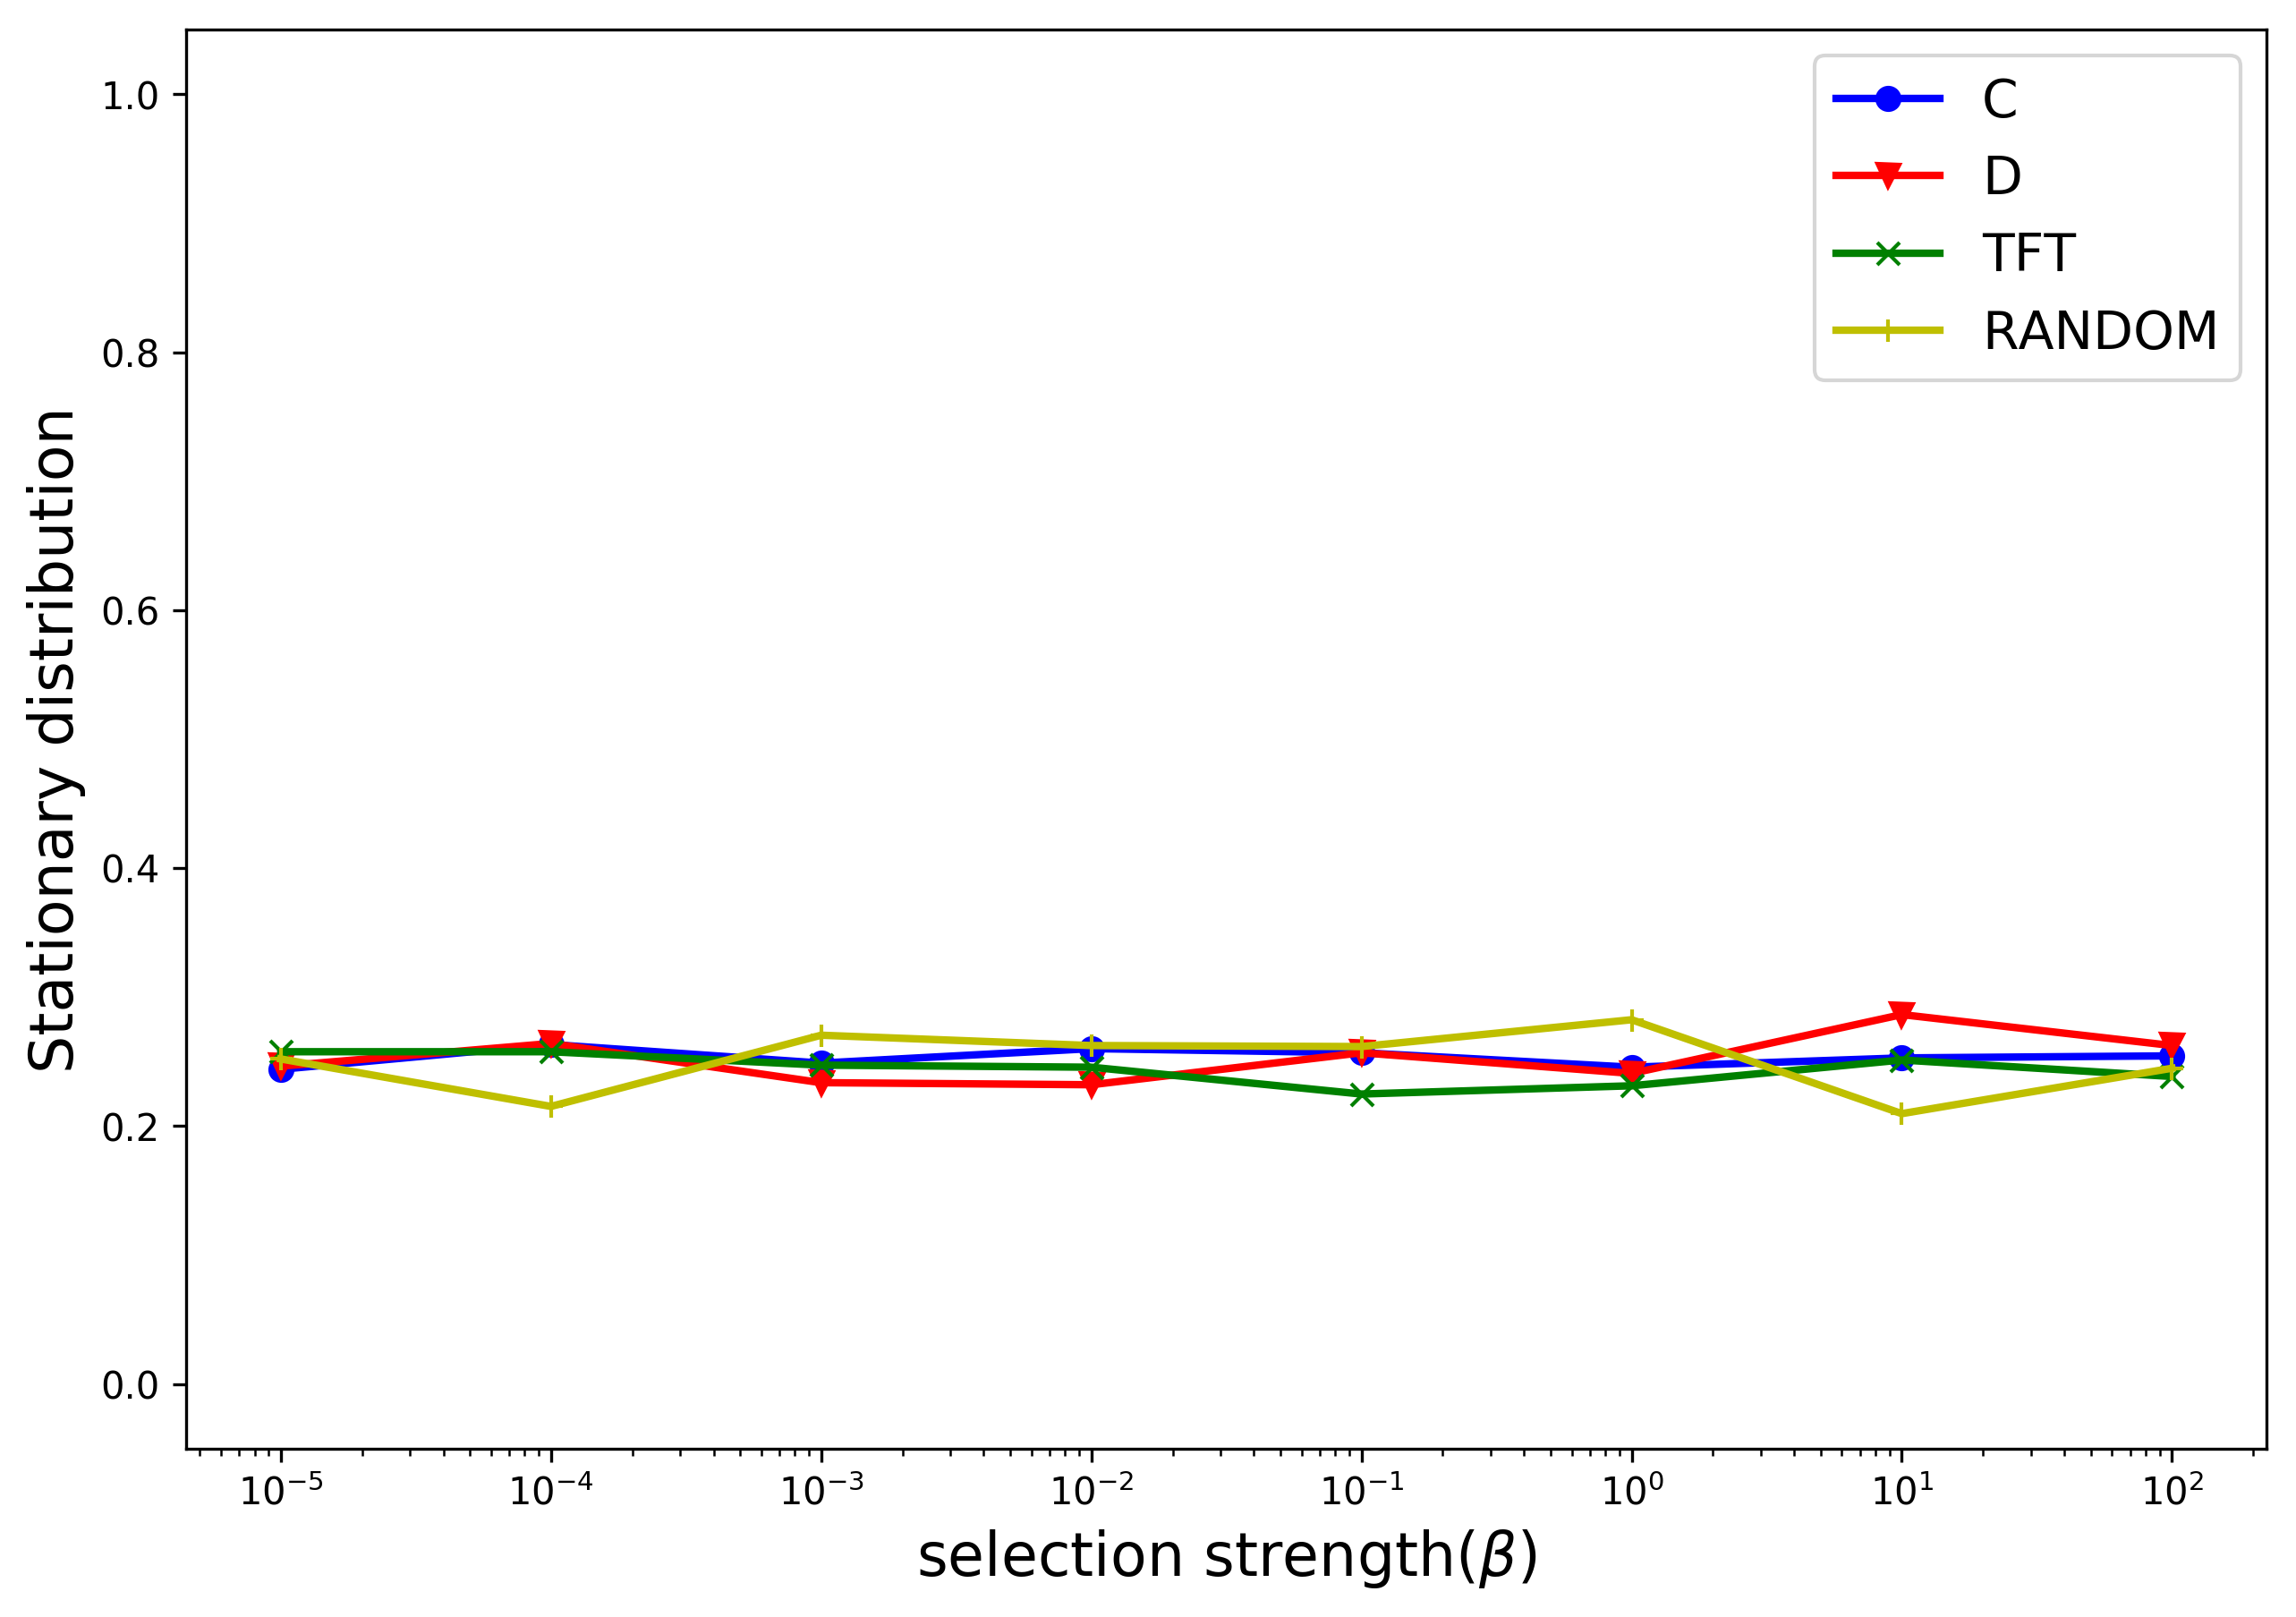

In [11]:
fig = plt.figure(figsize=(10, 7), dpi=150)
threshold = 100
lines=plt.plot(betas,np.mean(np.mean(freq_vector[:, :, -threshold:, 0], axis=2), axis=1),'bo-',
               betas,np.mean(np.mean(freq_vector[:, :, -threshold:, 1], axis=2), axis=1),'rv-', 
               betas,np.mean(np.mean(freq_vector[:, :, -threshold:, 2], axis=2), axis=1),'gx-',
               betas,np.mean(np.mean(freq_vector[:, :, -threshold:, 3], axis=2), axis=1),'y+-')
plt.rc("font", size=14)
plt.xscale('log')
plt.setp(lines, linewidth=2.0)
plt.ylabel('Stationary distribution',size=16)
plt.xlabel('selection strength'+r'($\beta$)',size=16)
plt.ylim(-0.05,1.05)
plt.legend(strats)
plt.show()